In [8]:
from pathlib import Path
import numpy as np
import pandas as pd
import trimesh

step_path = Path(r"C:\Users\abrik\Desktop\Work\Ballsnow\Code\Xiaomi\DPUB-501020596-XAX_03.002.stp")
glb_path  = Path("exports_actual_catias") / "DPUB-501020596-XAX_03.002.glb"

# --- welds from STEP (same as before) ---
def extract_rsw_points(step_file: Path, encoding: str = "latin-1") -> pd.DataFrame:
    import re
    with open(step_file, "r", encoding=encoding, errors="ignore") as f:
        text = f.read()

    pattern = re.compile(
        r"#\d+\s*=\s*CARTESIAN_POINT\('([^']*RSW[^']*)',\s*\(([^)]*)\)\s*\)\s*;",
        re.DOTALL,
    )

    rows = []
    for name, coords_str in pattern.findall(text):
        parts = [p for p in re.split(r"[,\s]+", coords_str.strip()) if p]
        try:
            coords = [float(p) for p in parts]
        except ValueError:
            continue
        if len(coords) == 3:
            rows.append({"name": name, "x": coords[0], "y": coords[1], "z": coords[2]})

    return pd.DataFrame(rows)

weld_df = extract_rsw_points(step_path)
print("RSW weld points:", len(weld_df))
display(weld_df.head())

weld_points = weld_df[["x", "y", "z"]].to_numpy(dtype=float)

# --- body parts from GLB ---
obj = trimesh.load(glb_path)
print(type(obj))

part_meshes = []

if isinstance(obj, trimesh.Scene):
    # each entry in obj.geometry is typically one CATIA sub-part
    for name, geom in obj.geometry.items():
        if not isinstance(geom, trimesh.Trimesh):
            continue
        # skip super tiny fragments
        if geom.faces.shape[0] < 100:
            continue
        part_meshes.append((name, geom))
else:
    part_meshes.append(("body", obj))

print("Number of GLB parts kept:", len(part_meshes))
for name, m in part_meshes[:10]:
    print(f"{name}: verts={len(m.vertices)}, faces={len(m.faces)}")


RSW weld points: 66


,name,x,y,z
0,T16A-0000001286-RSW-GSMPoint.427,3700.882639,218.260034,229.142181
1,T16A-0000001288-RSW-GSMPoint.433,3700.882639,-218.260034,229.142181
2,T16A-0000001298-RSW-GSMPoint.449,3707.882639,171.297429,230.142181
3,T16A-0000001300-RSW-GSMPoint.451,3707.882639,91.115654,230.142181
4,T16A-0000001301-RSW-GSMPoint.452,3707.882639,-91.115654,230.142181


<class 'trimesh.scene.scene.Scene'>
Number of GLB parts kept: 220
SHELL_119: verts=110, faces=112
SOLID_292: verts=110, faces=112
SOLID_300: verts=110, faces=112
SOLID_1403: verts=97, faces=153
SOLID_1404: verts=70, faces=104
SOLID_1418: verts=97, faces=153
SOLID_1419: verts=70, faces=104
SOLID_1433: verts=97, faces=153
SOLID_1434: verts=70, faces=104
SOLID_1448: verts=97, faces=153


PyVista parts: 220


c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


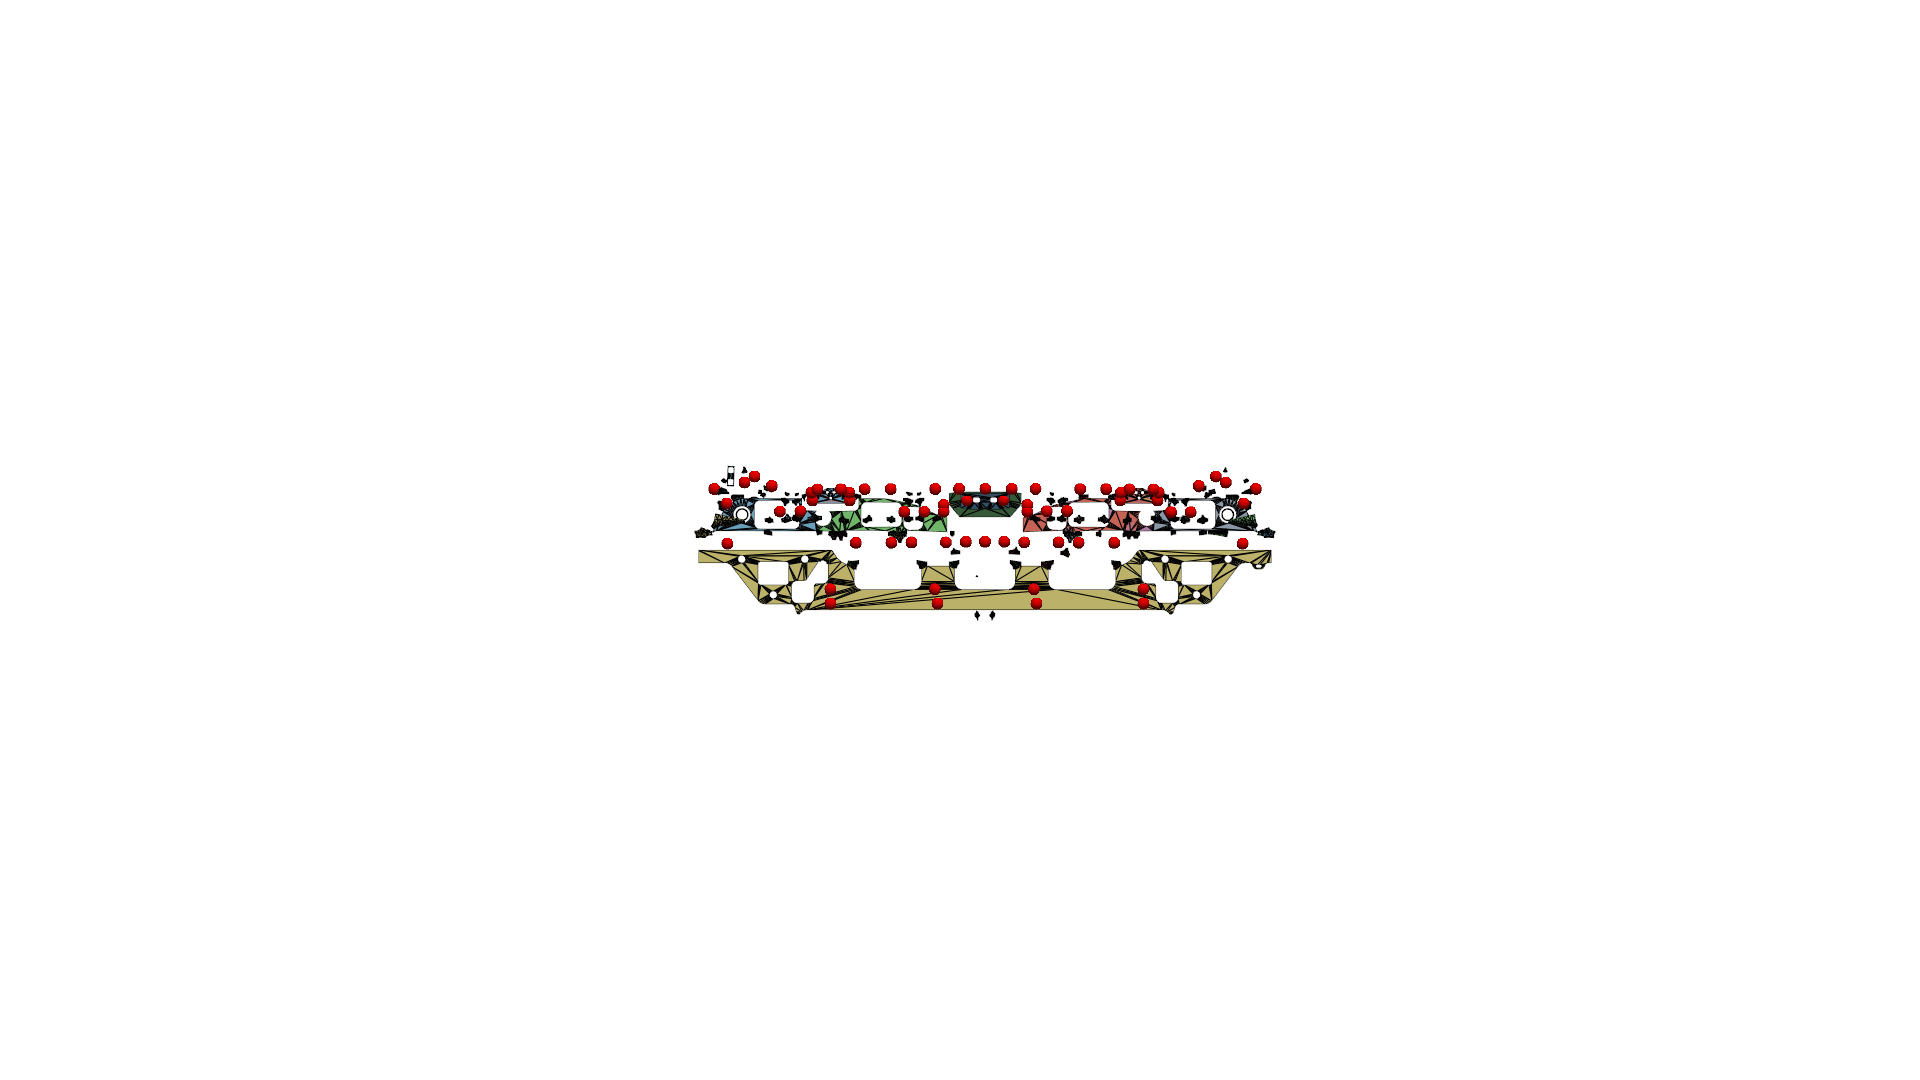

Saved: exports_pv_parts\front_parts_welds.png


c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


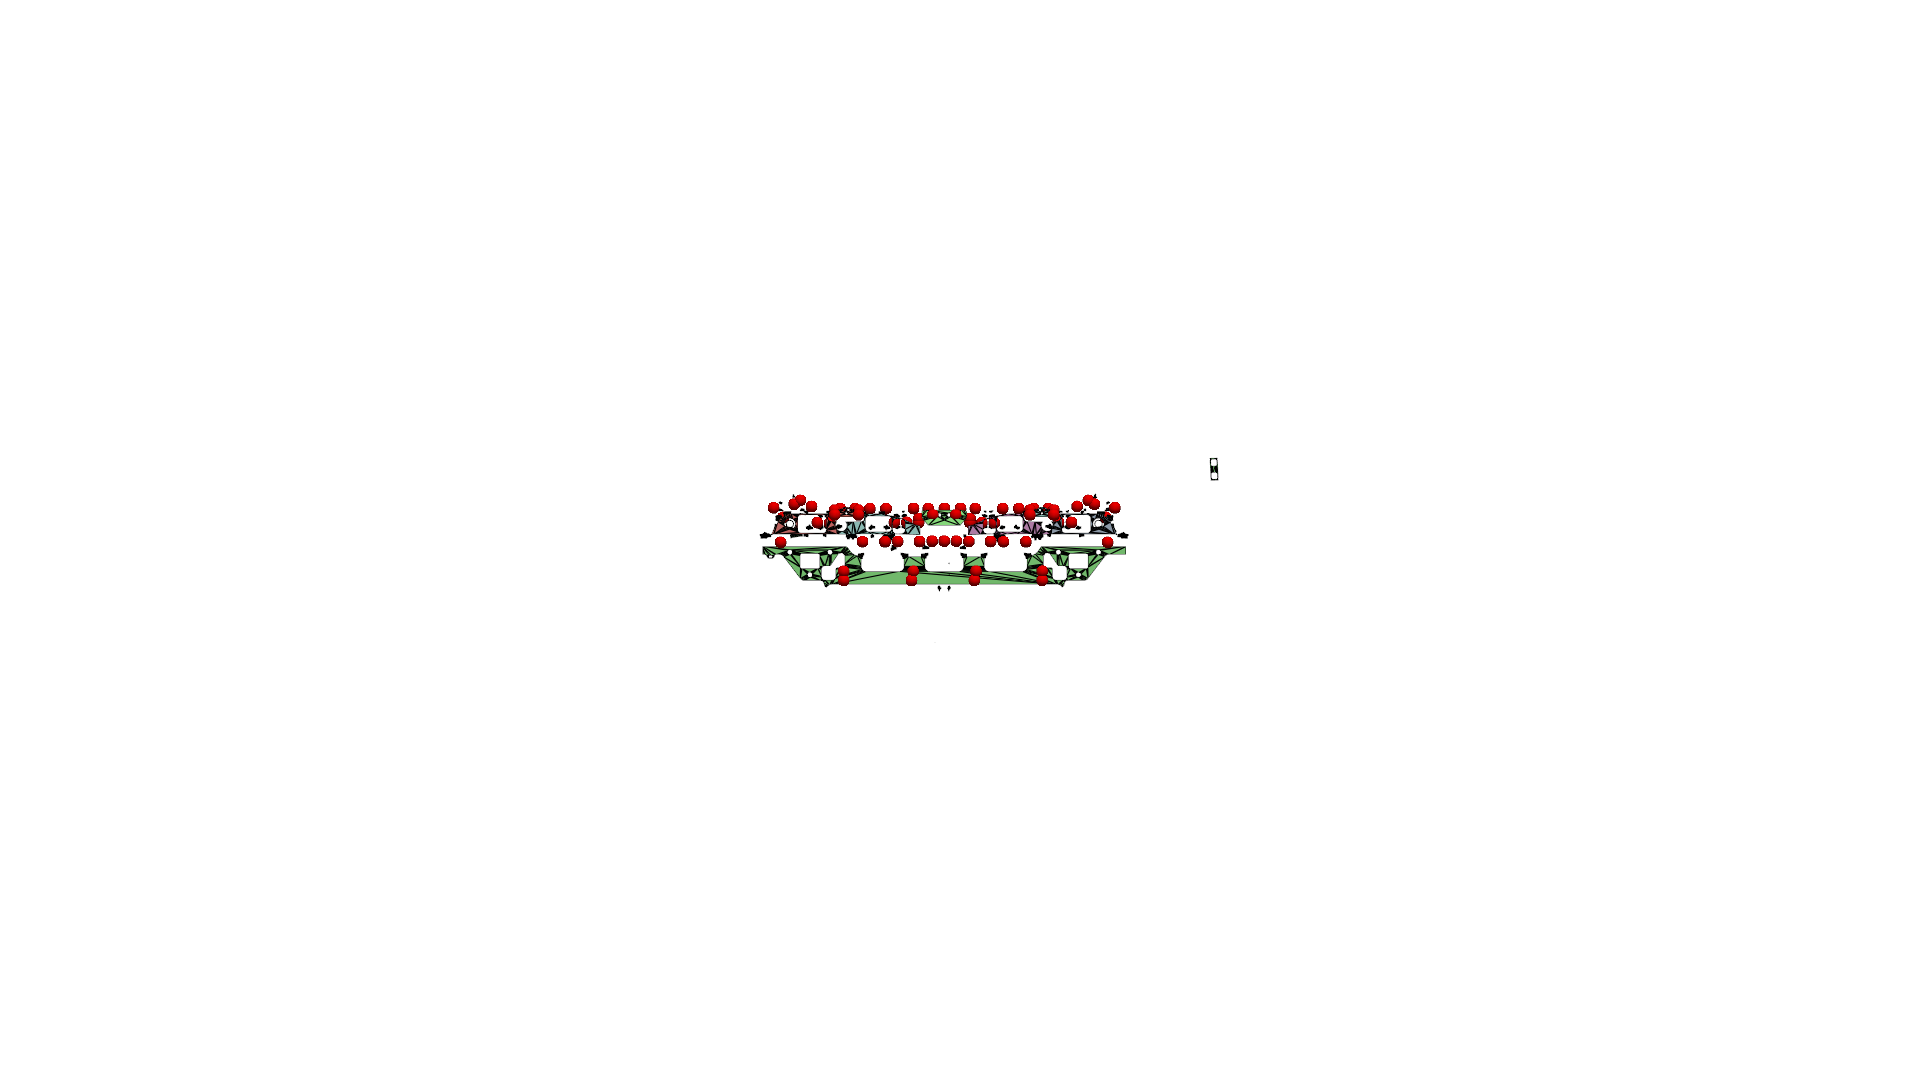

Saved: exports_pv_parts\rear_parts_welds.png


c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


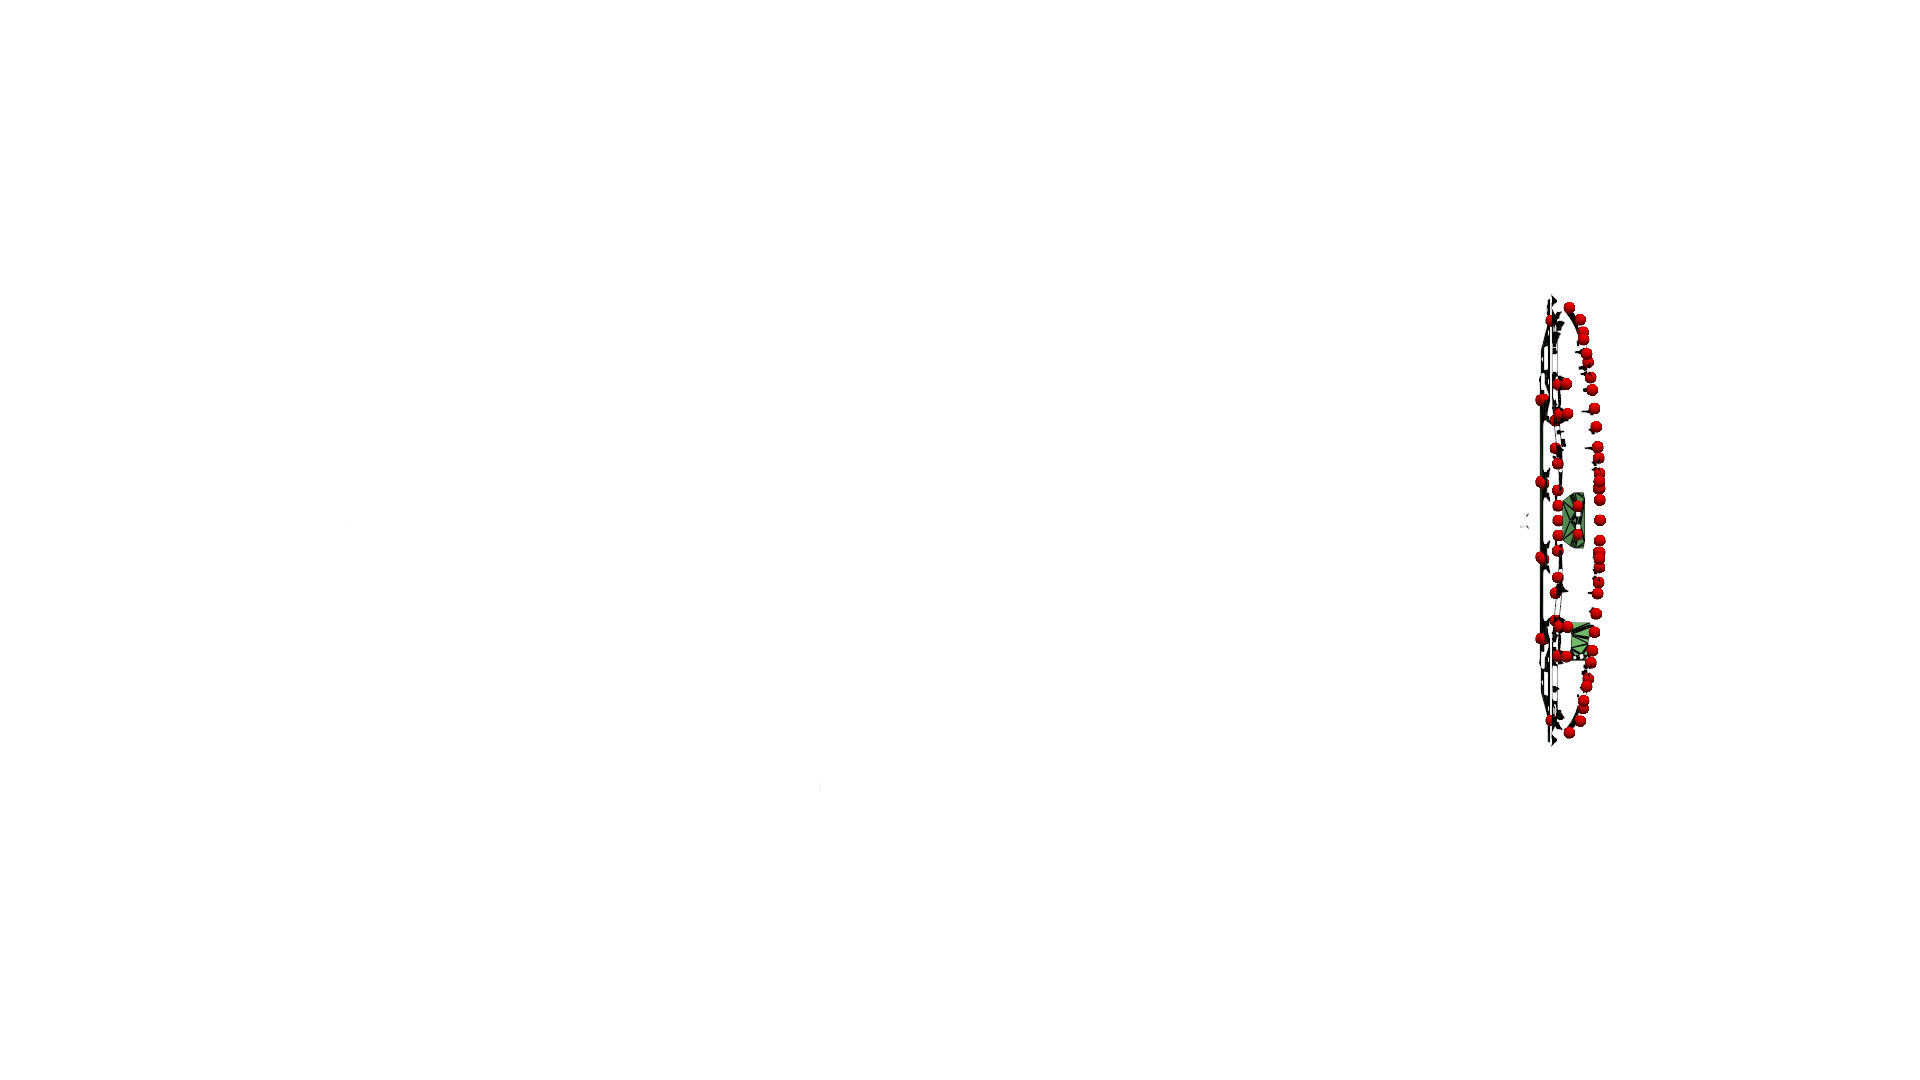

Saved: exports_pv_parts\top_parts_welds.png


c:\Users\abrik\miniconda3\envs\ballsnow_reconstruct\lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


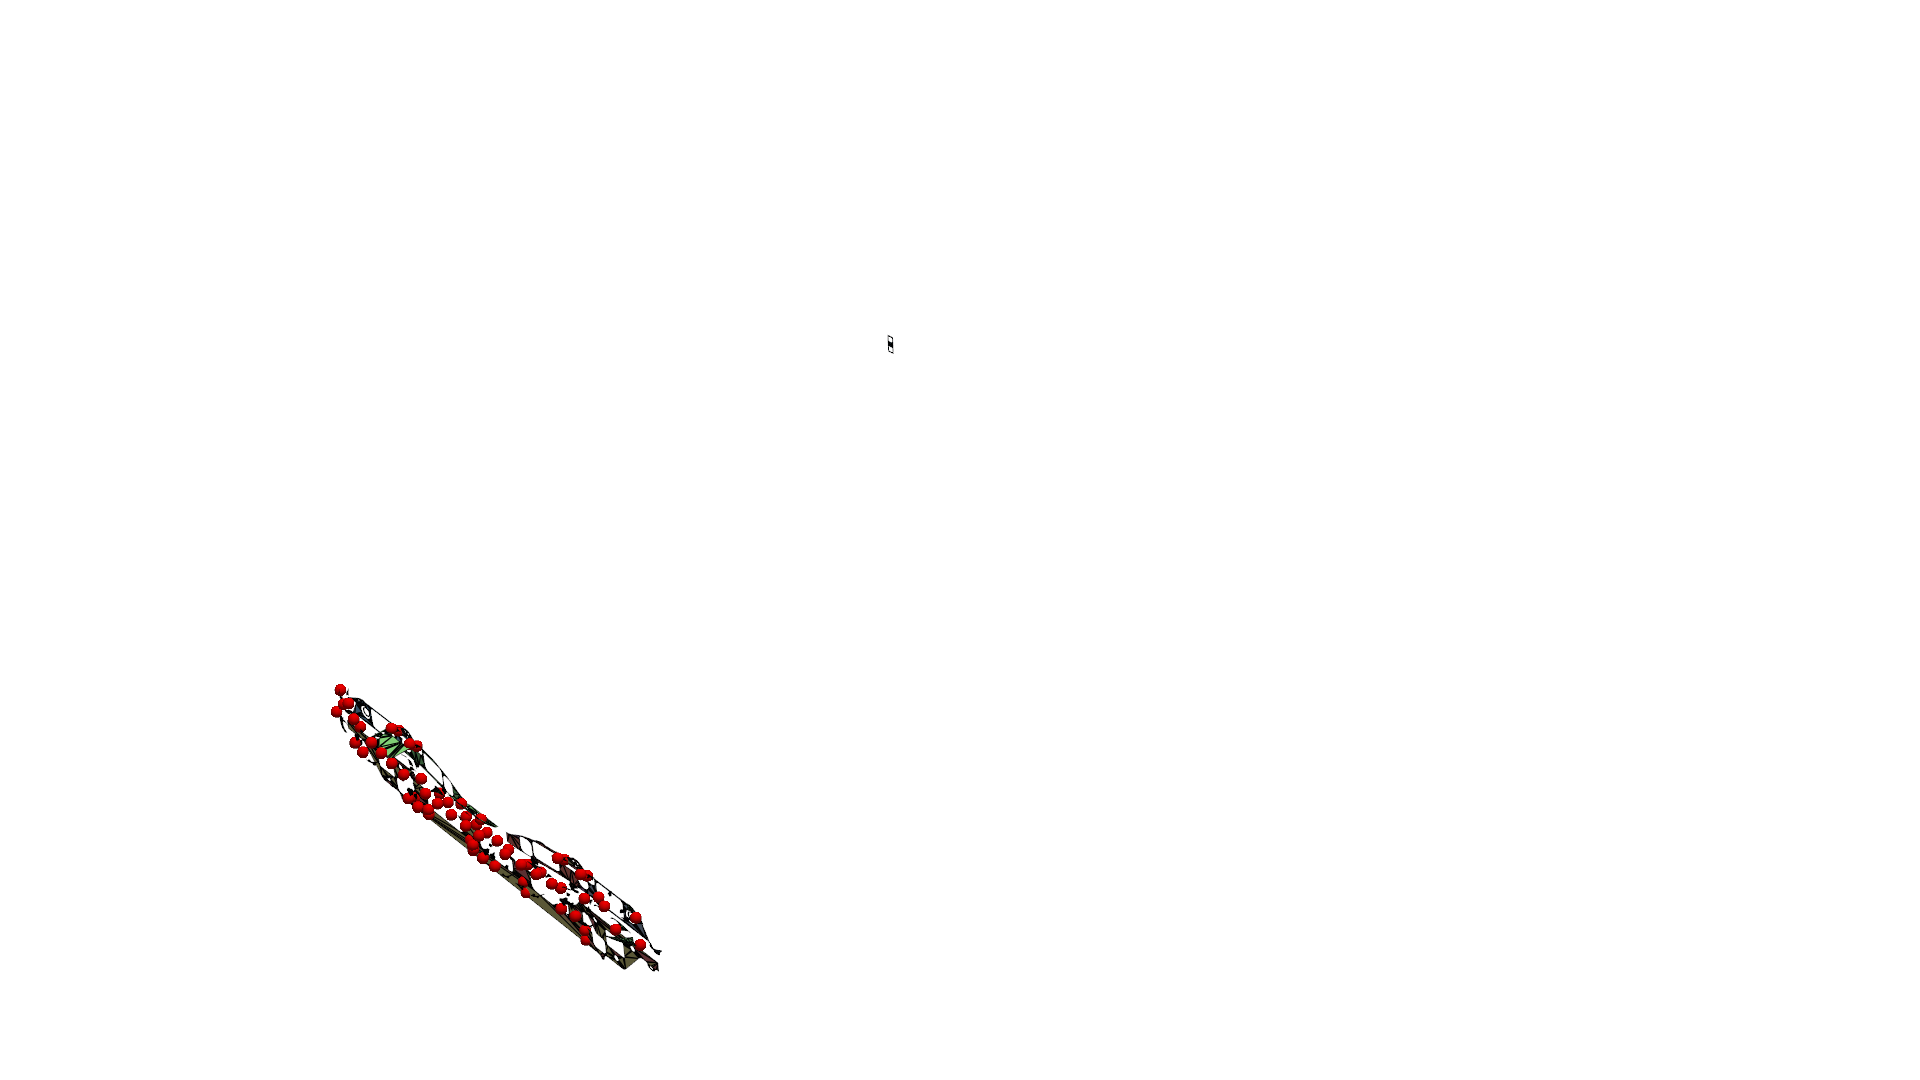

Saved: exports_pv_parts\iso_parts_welds.png


In [9]:
import pyvista as pv
from pathlib import Path

out_dir = Path("exports_pv_parts")
out_dir.mkdir(exist_ok=True, parents=True)

# convert each trimesh part to a PyVista PolyData
pv_parts = []
for name, m in part_meshes:
    v = np.asarray(m.vertices, dtype=float)
    f = np.asarray(m.faces, dtype=np.int64)
    if f.size == 0:
        continue
    faces_pv = np.hstack([np.full((f.shape[0], 1), 3, np.int64), f]).ravel()
    mesh_pv = pv.PolyData(v, faces_pv)
    pv_parts.append((name, mesh_pv))

print("PyVista parts:", len(pv_parts))


# simple color palette to cycle through
part_colors = [
    "lightsteelblue",
    "paleturquoise",
    "lightskyblue",
    "lightgreen",
    "khaki",
    "plum",
    "salmon",
    "lightcoral",
]

def make_view(set_view_fn, filename, show_welds=True, zoom=1.3):
    p = pv.Plotter(off_screen=True, window_size=(1920, 1080))
    p.set_background("white")   # light background

    # add each part with a different color
    for idx, (name, mesh) in enumerate(pv_parts):
        color = part_colors[idx % len(part_colors)]
        p.add_mesh(
            mesh,
            color=color,
            smooth_shading=True,
            show_edges=True,
            edge_color="black",
            line_width=0.3,
            lighting=True,
        )

    # welds as red spheres
    if show_welds:
        p.add_points(
            weld_points,
            color="red",
            render_points_as_spheres=True,
            point_size=12,
        )

    set_view_fn(p)
    p.reset_camera()
    p.camera.zoom(zoom)

    p.show(screenshot=str(out_dir / filename))
    p.close()
    print("Saved:", out_dir / filename)


# view helpers (note: azimuth/elevation as properties, not callables)
def front_view(p):
    p.view_yz()

def rear_view(p):
    p.view_yz()
    p.camera.azimuth = 180.0

def top_view(p):
    p.view_xy()   # look down

def iso_view(p):
    p.view_isometric()


# generate views
make_view(front_view, "front_parts_welds.png")
make_view(rear_view,  "rear_parts_welds.png")
make_view(top_view,   "top_parts_welds.png")
make_view(iso_view,   "iso_parts_welds.png")
